# ResNet-50 for Cats.Vs.Dogs

In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Add, Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
import random
import os
import cv2
import sys


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


## Data preprocessing

- The images in train folder are divided into a training set and a validation set.
- The images both in training set and validation set are separately divided into two folders -- cat and dog according to their lables.

*(the two steps above were finished in  Preprocessing train dataset.ipynb)*

- The RGB color values of the images are rescaled to 0~1.
- The size of the images are resized to 224*224.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
image_width = 224
image_height = 224
image_size = (image_width, image_height)

train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory('Gtrain',
                                                    target_size=image_size,
                                                    batch_size=16,
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory('Gvalid',
                                                              target_size=image_size,
                                                              batch_size=16,
                                                              class_mode='binary')


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


#### show 16 images in the train dataset randomly

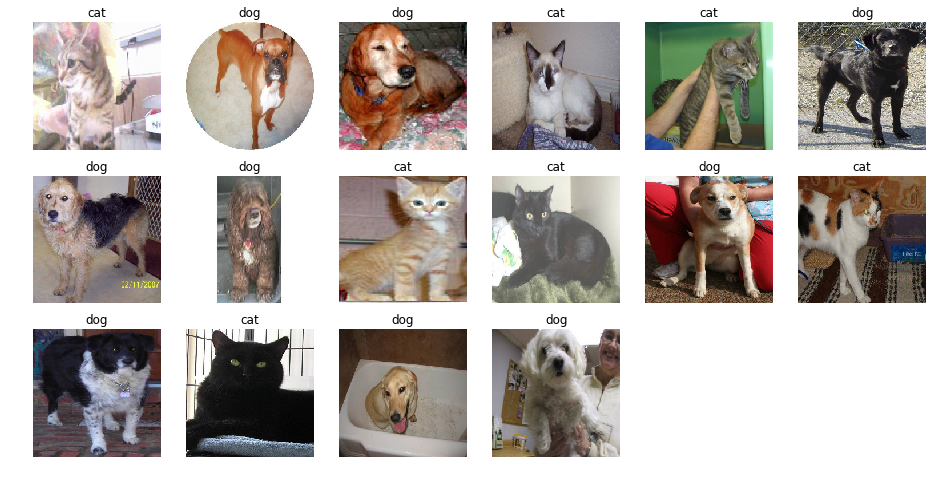

In [3]:
x, y = train_generator.__next__()


plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

## Build the structure of ResNet-50 for Cats.Vs.Dogs

1. Define identity block.
2. Define convolution block.
3. Build the structure of ResNet-50 without top layer.
4. Load weights
5. Add top layer to ResNet-50.
6. Setup training attribute.
7. Compile the model.

### 1. Define identity block.

#### The identity_block is the block that has no conv layer at shortcut.

#### Arguments

- input_tensor: input tensor
- kernel_size: defualt 3, the kernel size of middle conv layer at main path
- filters: list of integers, the nb_filters of 3 conv layer at main path
- stage: integer, current stage label, used for generating layer names
-  block: 'a','b'..., current block label, used for generating layer names

In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1,(1, 1),name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b')(x)                  
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3,(1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

### 2. Define convolution block.

#### conv_block is the block that has a conv layer at shortcut

#### Arguments

- input_tensor: input tensor
- kernel_size: defualt 3, the kernel size of middle conv layer at main path
- filters: list of integers, the nb_filters of 3 conv layer at main path
- stage: integer, current stage label, used for generating layer names
- block: 'a','b'..., current block label, used for generating layer names

    *Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well*

In [5]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    nb_filter1, nb_filter2, nb_filter3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(nb_filter1,(1, 1),strides=strides,name=conv_name_base + '2a')(input_tensor)

    
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding ='same',name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

### 3.Build the structure of ResNet-50 without top layer.

In [6]:
img_input = Input(shape=(image_width, image_height, 3))

x = ZeroPadding2D((3, 3))(img_input)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

base_model = Model(img_input, x)

### 4. Load weights.

In [7]:
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/\
v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        TF_WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        md5_hash='a268eb855778b3df3c7506639542a6af')
base_model.load_weights(weights_path)

### 5. Add top layer to ResNet-50.

In [8]:
x = AveragePooling2D((7, 7), name='avg_pool')(base_model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=base_model.input, outputs=x)

### 6. Setup training attribute.

*Freeze the weights except the top layer.*

In [9]:
top_num = 4
for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True

### 7. Compile the model.

In [10]:
#model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
#from keras import optimizers
#Adadelta = optimizers.(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

## Train ResNet-50 for Cats.Vs.Dogs and Save the best model.

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard
best_model = ModelCheckpoint("resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [12]:
model.fit_generator(
        train_generator,
        steps_per_epoch=128,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=64,
        callbacks=[best_model, TensorBoard(log_dir='./logs', histogram_freq=0)])

Epoch 1/40
128/128 [==============================] - 54s 425ms/step - loss: 0.3567 - acc: 0.8442 - val_loss: 1.1038 - val_acc: 0.4775
Epoch 2/40
128/128 [==============================] - 52s 408ms/step - loss: 0.1864 - acc: 0.9243 - val_loss: 1.1494 - val_acc: 0.4775
Epoch 3/40
128/128 [==============================] - 52s 408ms/step - loss: 0.1500 - acc: 0.9375 - val_loss: 1.1457 - val_acc: 0.4775
Epoch 4/40
128/128 [==============================] - 52s 408ms/step - loss: 0.1448 - acc: 0.9375 - val_loss: 1.4212 - val_acc: 0.4775
Epoch 5/40
128/128 [==============================] - 52s 408ms/step - loss: 0.1380 - acc: 0.9448 - val_loss: 1.5091 - val_acc: 0.4775
Epoch 6/40
128/128 [==============================] - 52s 409ms/step - loss: 0.1439 - acc: 0.9424 - val_loss: 1.4646 - val_acc: 0.4775
Epoch 7/40
128/128 [==============================] - 52s 408ms/step - loss: 0.1557 - acc: 0.9385 - val_loss: 1.4664 - val_acc: 0.4775
Epoch 8/40
128/128 [==============================] - 5